In [58]:
import pandas as pd
import numpy as np
from datetime import datetime
data_dir = "/home/wang/projects/CaseStudies/flixbus/data/"
channels = pd.read_csv(data_dir + "orders_channels.csv")
tickets = pd.read_csv(data_dir + "orders_tickets.csv")
country = pd.read_csv(data_dir + "orders_country.csv")
tmp = pd.merge(channels, tickets, on='id')
dat = pd.merge(tmp, country, on='id')
col = 'country_1'
dat[col] = dat[col].fillna(-1)
dat[col] = dat[col].astype(int)
# dat[col] = dat[col].astype(str)
# dat[col] = dat[col].replace('-1', np.nan)
col = 'channel_id'
dat[col] = dat[col].fillna(-1)
dat[col] = dat[col].astype(int)
# dat[col] = dat[col].astype(str)
# dat[col] = dat[col].replace('-1', np.nan)
col = 'country_2'
dat.loc[:, col] = dat[col].apply(lambda x: np.nan if x == 'xx' else x)
dat[col] = dat[col].fillna(-1)
dat[col] = dat[col].astype(int)
# dat[col] = dat[col].astype(str)
# dat[col] = dat[col].replace('-1', np.nan)
dat1 = dat[~((dat.country_1 == -1) | (dat.country_2 == -1))].melt(id_vars = ['id', 'date', 'channel_id', 'n_tickets', 'type'], value_name = "country").drop('variable', axis=1)
dat2 = dat.loc[dat.country_1 == -1, :].drop('country_1', axis=1)
dat2.rename(columns = {'country_2':'country'}, inplace = True)
dat3 = dat.loc[dat.country_2 == -1, :].drop('country_2', axis=1)
dat3.rename(columns = {'country_1':'country'}, inplace = True)
dat = pd.concat([dat1, dat2, dat3], sort=False)
dat = dat.loc[dat.country != -1, :]
dat = dat.loc[dat.channel_id != -1, :]
dat['date_diff'] = dat.apply(lambda x: (datetime.strptime(x.date, "%Y-%m-%d") - datetime.strptime('2017-01-01', "%Y-%m-%d")).days, axis=1)
dat = dat.drop(['date', 'id', 'type'], axis=1)
dat = dat.groupby(['date_diff','country', 'channel_id']).sum().reset_index()
dat = dat.sample(frac=1).reset_index(drop=True)
dat_nondummy = dat

# Look into data

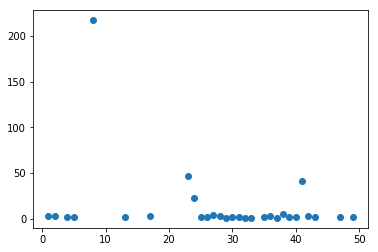

In [165]:
from matplotlib import pyplot as plt 
plt.scatter(x=dat_nondummy['channel_id'].unique(), y=dat_nondummy.groupby(['channel_id']).mean().n_tickets)
plt.show()

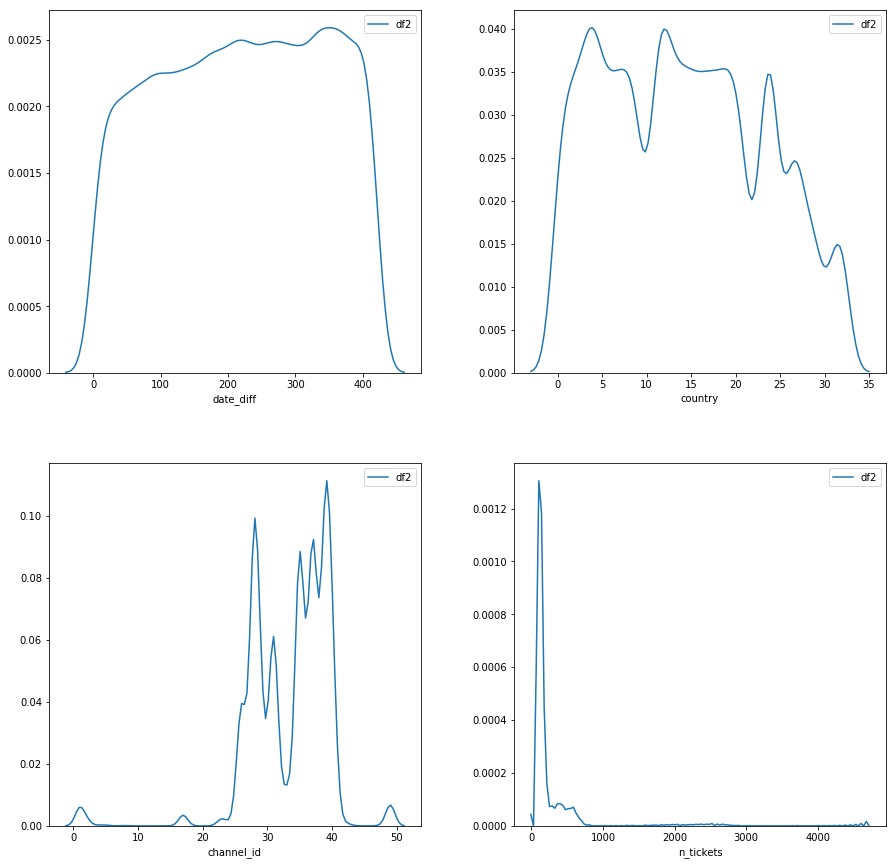

In [166]:
%matplotlib inline
import seaborn as sns
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
import itertools

def compare_distr(df1, df2):
    a = len(df1.columns)
    if a%2 != 0:
        a += 1
    
    n = np.floor(np.sqrt(a)).astype(np.int64)
    
    while a%n != 0:
        n -= 1
    
    m = (a/n).astype(np.int64)
    coords = list(itertools.product(list(range(m)), list(range(n))))
    
    numerics = df1.select_dtypes(include=[np.number]).columns
    cats = df1.select_dtypes(include=['category']).columns
    
    fig = plt.figure(figsize=(15, 15))
    axes = gs.GridSpec(m, n)
    axes.update(wspace=0.25, hspace=0.25)
    
    for i in range(len(numerics)):
        x, y = coords[i]
        ax = plt.subplot(axes[x, y])
        col = numerics[i]
        sns.kdeplot(df1[col].dropna(), ax=ax, label='df1').set(xlabel=col)
        sns.kdeplot(df2[col].dropna(), ax=ax, label='df2')
        
    for i in range(0, len(cats)):
        x, y = coords[len(numerics)+i]
        ax = plt.subplot(axes[x, y])
        col = cats[i]

        df1_temp = df1[col].value_counts()
        df2_temp = df2[col].value_counts()
        df1_temp = pd.DataFrame({col: df1_temp.index, 'value': df1_temp/len(df1), 'Set': np.repeat('df1', len(df1_temp))})
        df2_temp = pd.DataFrame({col: df2_temp.index, 'value': df2_temp/len(df2), 'Set': np.repeat('df2', len(df2_temp))})

        sns.barplot(x=col, y='value', hue='Set', data=pd.concat([df1_temp, df2_temp]), ax=ax).set(ylabel='Percentage')
compare_distr(dat_nondummy.loc[dat_nondummy.country==-1, :], dat_nondummy.loc[dat_nondummy.country!=-1, :])

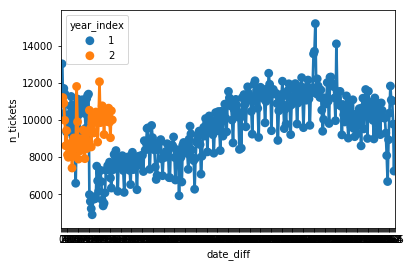

In [167]:
tmp = dat_nondummy.groupby('date_diff').sum().reset_index()
tmp['year_index'] = 1
tmp.loc[tmp.date_diff>365, 'year_index'] = 2
tmp.loc[tmp.date_diff>365, 'date_diff'] = tmp.loc[tmp.date_diff>365, 'date_diff']-365
sns.pointplot('date_diff', 'n_tickets', data=tmp, hue='year_index')

* 0.4% records have country_1 and country_2 both missing
* Some records have 'xx' for country_2, which should also be regarded as missing values
* By comparing records with known channel_id and without known channel_id, one can see similar distributions for other variables. So one can see that the channel_id is missed randomly. Similarly, one can also conclude that country_1 and country_2 are also missed randomly.
* No clear correlation between mean `n_tickets` and `country` index was found. So country was indexed randomly. Similarly, `channel_id` was also indexed randomly.

# Fit data

* 4-fold cross validation
* Fit data with KNeighborsRegressor, GradientBoostingRegressor and XGBRegressor
* Stack three models with Ridge regression

In [168]:
tmp = dat_nondummy.groupby(['date_diff','country', 'channel_id']).sum().reset_index()
tmp['year_index'] = 1
tmp.loc[tmp.date_diff>365, 'year_index'] = 2
tmp.loc[tmp.date_diff>365, 'date_diff'] = tmp.loc[tmp.date_diff>365, 'date_diff']-365
dat = pd.get_dummies(tmp, columns=['country', 'channel_id'])

In [173]:
from xgboost import XGBRegressor
import numpy as np
import pandas as pd
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.neighbors import KNeighborsRegressor
from skmisc.loess import loess
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
import seaborn as sns
from scipy import stats

class regression_model(object):
    def __init__(self, reg_model, params=None):
        self.reg_model = reg_model(**params)

    def train(self, X, y):
        self.reg_model.fit(X, y)   

    def predict(self, X):
        return self.reg_model.predict(X)
    
    def fit(self, X, y):
        return self.reg_model.fit(X, y)
    
def non_zero(a):
    return np.where(a < 0, 0, a) 

# kr = {"alpha":0.001, "kernel":'rbf', "gamma":0.6}
gr = {"max_depth": 3, "random_state": 15}
knn = {"n_neighbors": 3}
xgb = {"max_depth": 6, "gamma": 0.001, "subsample": 0.7, "random_state": 15, 'nthread': 7}
methods = ['gr', 'knn', "xgb"]
predictors = [val for val in dat.columns.values.tolist() if val != 'n_tickets']
X = dat[predictors]
y = dat['n_tickets']

pred = pd.DataFrame(np.empty((X.shape[0], len(methods))), columns=methods)
n_folds = 4
scores = np.zeros(n_folds)
i = 0
kf = KFold(n_splits=n_folds, shuffle=True, random_state=1354)
for train, test in kf.split(X):
    X_train = X.iloc[train, :]
    y_train = y.iloc[train]
    X_test = X.iloc[test, :]
    y_test = y.iloc[test]
    
#     name_method = methods[0]
#     model = regression_model(reg_model=KernelRidge, params=eval(name_method))
#     model.fit(X_train, y_train)
#     pred[name_method][test] = model.predict(X_test)
    
    name_method = methods[0]
    model = regression_model(reg_model=GradientBoostingRegressor, params=eval(name_method))
    model.fit(X_train, y_train)
    pred[name_method][test] = non_zero(model.predict(X_test))
    
    name_method = methods[1]
    model = regression_model(reg_model=KNeighborsRegressor, params=eval(name_method))
    model.fit(X_train, y_train)
    pred[name_method][test] = non_zero(model.predict(X_test))

    name_method = methods[2]
    model = regression_model(reg_model=XGBRegressor, params=eval(name_method))
    model.fit(X_train, y_train)
    pred[name_method][test] = non_zero(model.predict(X_test))
    
scores = np.zeros(n_folds)
i = 0
for train, test in kf.split(X):
    X_train = pred.iloc[train, :]
    y_train = y.iloc[train]
    X_test = pred.iloc[test, :]
    y_test = y.iloc[test]
    
    model = regression_model(reg_model=Ridge, params={"alpha": 10})
    model.fit(X_train, y_train)
    
    scores[i] = mean_squared_error(y_test, model.predict(X_test))
    i += 1
print(scores.mean())



673.947441354072


In [174]:
secondary_model = model
predictors = [val for val in dat.columns.values.tolist() if val != 'n_tickets']
X = dat[predictors]
y = dat['n_tickets']

name_method = methods[0]
model0 = regression_model(reg_model=GradientBoostingRegressor, params=eval(name_method))
model0.fit(X, y)

name_method = methods[1]
model1 = regression_model(reg_model=KNeighborsRegressor, params=eval(name_method))
model1.fit(X, y)

name_method = methods[2]
model2 = regression_model(reg_model=XGBRegressor, params=eval(name_method))
model2.fit(X, y)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.001, learning_rate=0.1,
       max_delta_step=0, max_depth=6, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=7, objective='reg:linear',
       random_state=15, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.7)

# Now predict with the stacked model

In [175]:
data_dir = "/home/wang/projects/CaseStudies/flixbus/data/"
channels = pd.read_csv(data_dir + "orders_channels.csv")
tickets = pd.read_csv(data_dir + "orders_tickets.csv")
country = pd.read_csv(data_dir + "orders_country.csv")
tmp = pd.merge(channels, tickets, on='id')
data = pd.merge(tmp, country, on='id')
col = 'country_1'
data[col] = data[col].fillna(-1)
data[col] = data[col].astype(int)
col = 'channel_id'
data[col] = data[col].fillna(-1)
data[col] = data[col].astype(int)
col = 'country_2'
data.loc[:, col] = data[col].apply(lambda x: np.nan if x == 'xx' else x)
data[col] = data[col].fillna(-1)
data[col] = data[col].astype(int)
dat1 = data[~((data.country_1 == -1) | (data.country_2 == -1))].melt(id_vars = ['id', 'date', 'channel_id', 'n_tickets', 'type'], value_name = "country").drop('variable', axis=1)
dat2 = data.loc[data.country_1 == -1, :].drop('country_1', axis=1)
dat2.rename(columns = {'country_2':'country'}, inplace = True)
dat3 = data.loc[data.country_2 == -1, :].drop('country_2', axis=1)
dat3.rename(columns = {'country_1':'country'}, inplace = True)
data = pd.concat([dat1, dat2, dat3], sort=False)
data = data.loc[data.country != -1, :]
data = data.loc[data.channel_id != -1, :]
channel = pd.unique(data.channel_id)
country = pd.unique(data.country)

In [176]:
import itertools
from datetime import timedelta
date_begin = (datetime.today() - datetime.strptime('2017-01-01', "%Y-%m-%d")).days - 2*365
date_end = (datetime.today() - datetime.strptime('2017-01-01', "%Y-%m-%d")).days + 11  - 2*365
date_diff = np.array(list(range(date_begin, date_end + 1)))
lists = [channel, country, date_diff]
data_test = pd.DataFrame(list(itertools.product(*lists)), columns=['channel_id', 'country', 'date_diff'])
data_test['year_index'] = 3
data_test['date'] = data_test.apply(lambda x: timedelta(days=int(x.date_diff + 365*2)) + datetime.strptime('2017-01-01', "%Y-%m-%d"), axis=1)
data_test_dummy = pd.get_dummies(data_test, columns=['country', 'channel_id'])

In [177]:
pred = pd.DataFrame()
name_method = methods[0]
pred[name_method] = non_zero(model0.predict(data_test_dummy.drop('date', axis=1)))
name_method = methods[1]
pred[name_method] = non_zero(model1.predict(data_test_dummy.drop('date', axis=1)))
name_method = methods[2]
pred[name_method] = non_zero(model2.predict(data_test_dummy.drop('date', axis=1)))
pred = non_zero(model.predict(pred))
data_test['n_tickets'] = pred
data_test = data_test.round(pd.Series([0], index=['n_tickets']))
data_test['n_tickets'] = data_test['n_tickets'].astype(np.int64)
data_test = data_test.drop(['date_diff', 'year_index'], axis=1)
data_test = data_test.loc[data_test.n_tickets != 0]
data_test = data_test.sort_values(by=['date', 'country', 'channel_id'])
data_test.rename(inplace = True, columns={'channel_id': 'channel'})
data_test = data_test.reset_index(drop=True)

In [187]:
data_test.to_csv(data_dir + 'predicted_result_wang.csv', columns=["date","country","channel", 'n_tickets'], index=False)

In [186]:
data_test[["date","country","channel", 'n_tickets']].head()

,date,country,channel,n_tickets
0,2019-03-11,0,28,15
1,2019-03-11,0,31,1
2,2019-03-11,0,35,7
3,2019-03-11,0,37,13
4,2019-03-11,0,39,74


# Answers

* How did you do it?

I used three models and stacked them with Ridge regression.

* Which statistics / criteria / assumptions did you use / make?

The assumption is that `n_tickets` is a function of country, channel, time of the year, and treand accross different years.

* What difficulties did you find during the process?

I found some rare categories of country-channel combinations.

* Please share with us a screenshot of your code

Please see above.